In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from hiEEG_functions import *

# Style
sns.set_theme(context='talk', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# iEEG Macroelectrode Data (4kHz)

In [3]:
folder='data/hiEEG'

# Load file manually
# file_string = f'Data_Subject_{1:02d}_Session_{1:02d}'
# f = h5py.File(os.path.join(folder, file_string) + '.h5', 'r')

# Load file automatically
data, meta = load_iEEG_macro(1, 1, folder=folder)


In [15]:
folder='data/hiEEG'

# Load file manually
file_string = f'Data_Subject_{1:02d}_Session_{1:02d}'
f = h5py.File(os.path.join(folder, file_string) + '.h5', 'r')


## Visualize

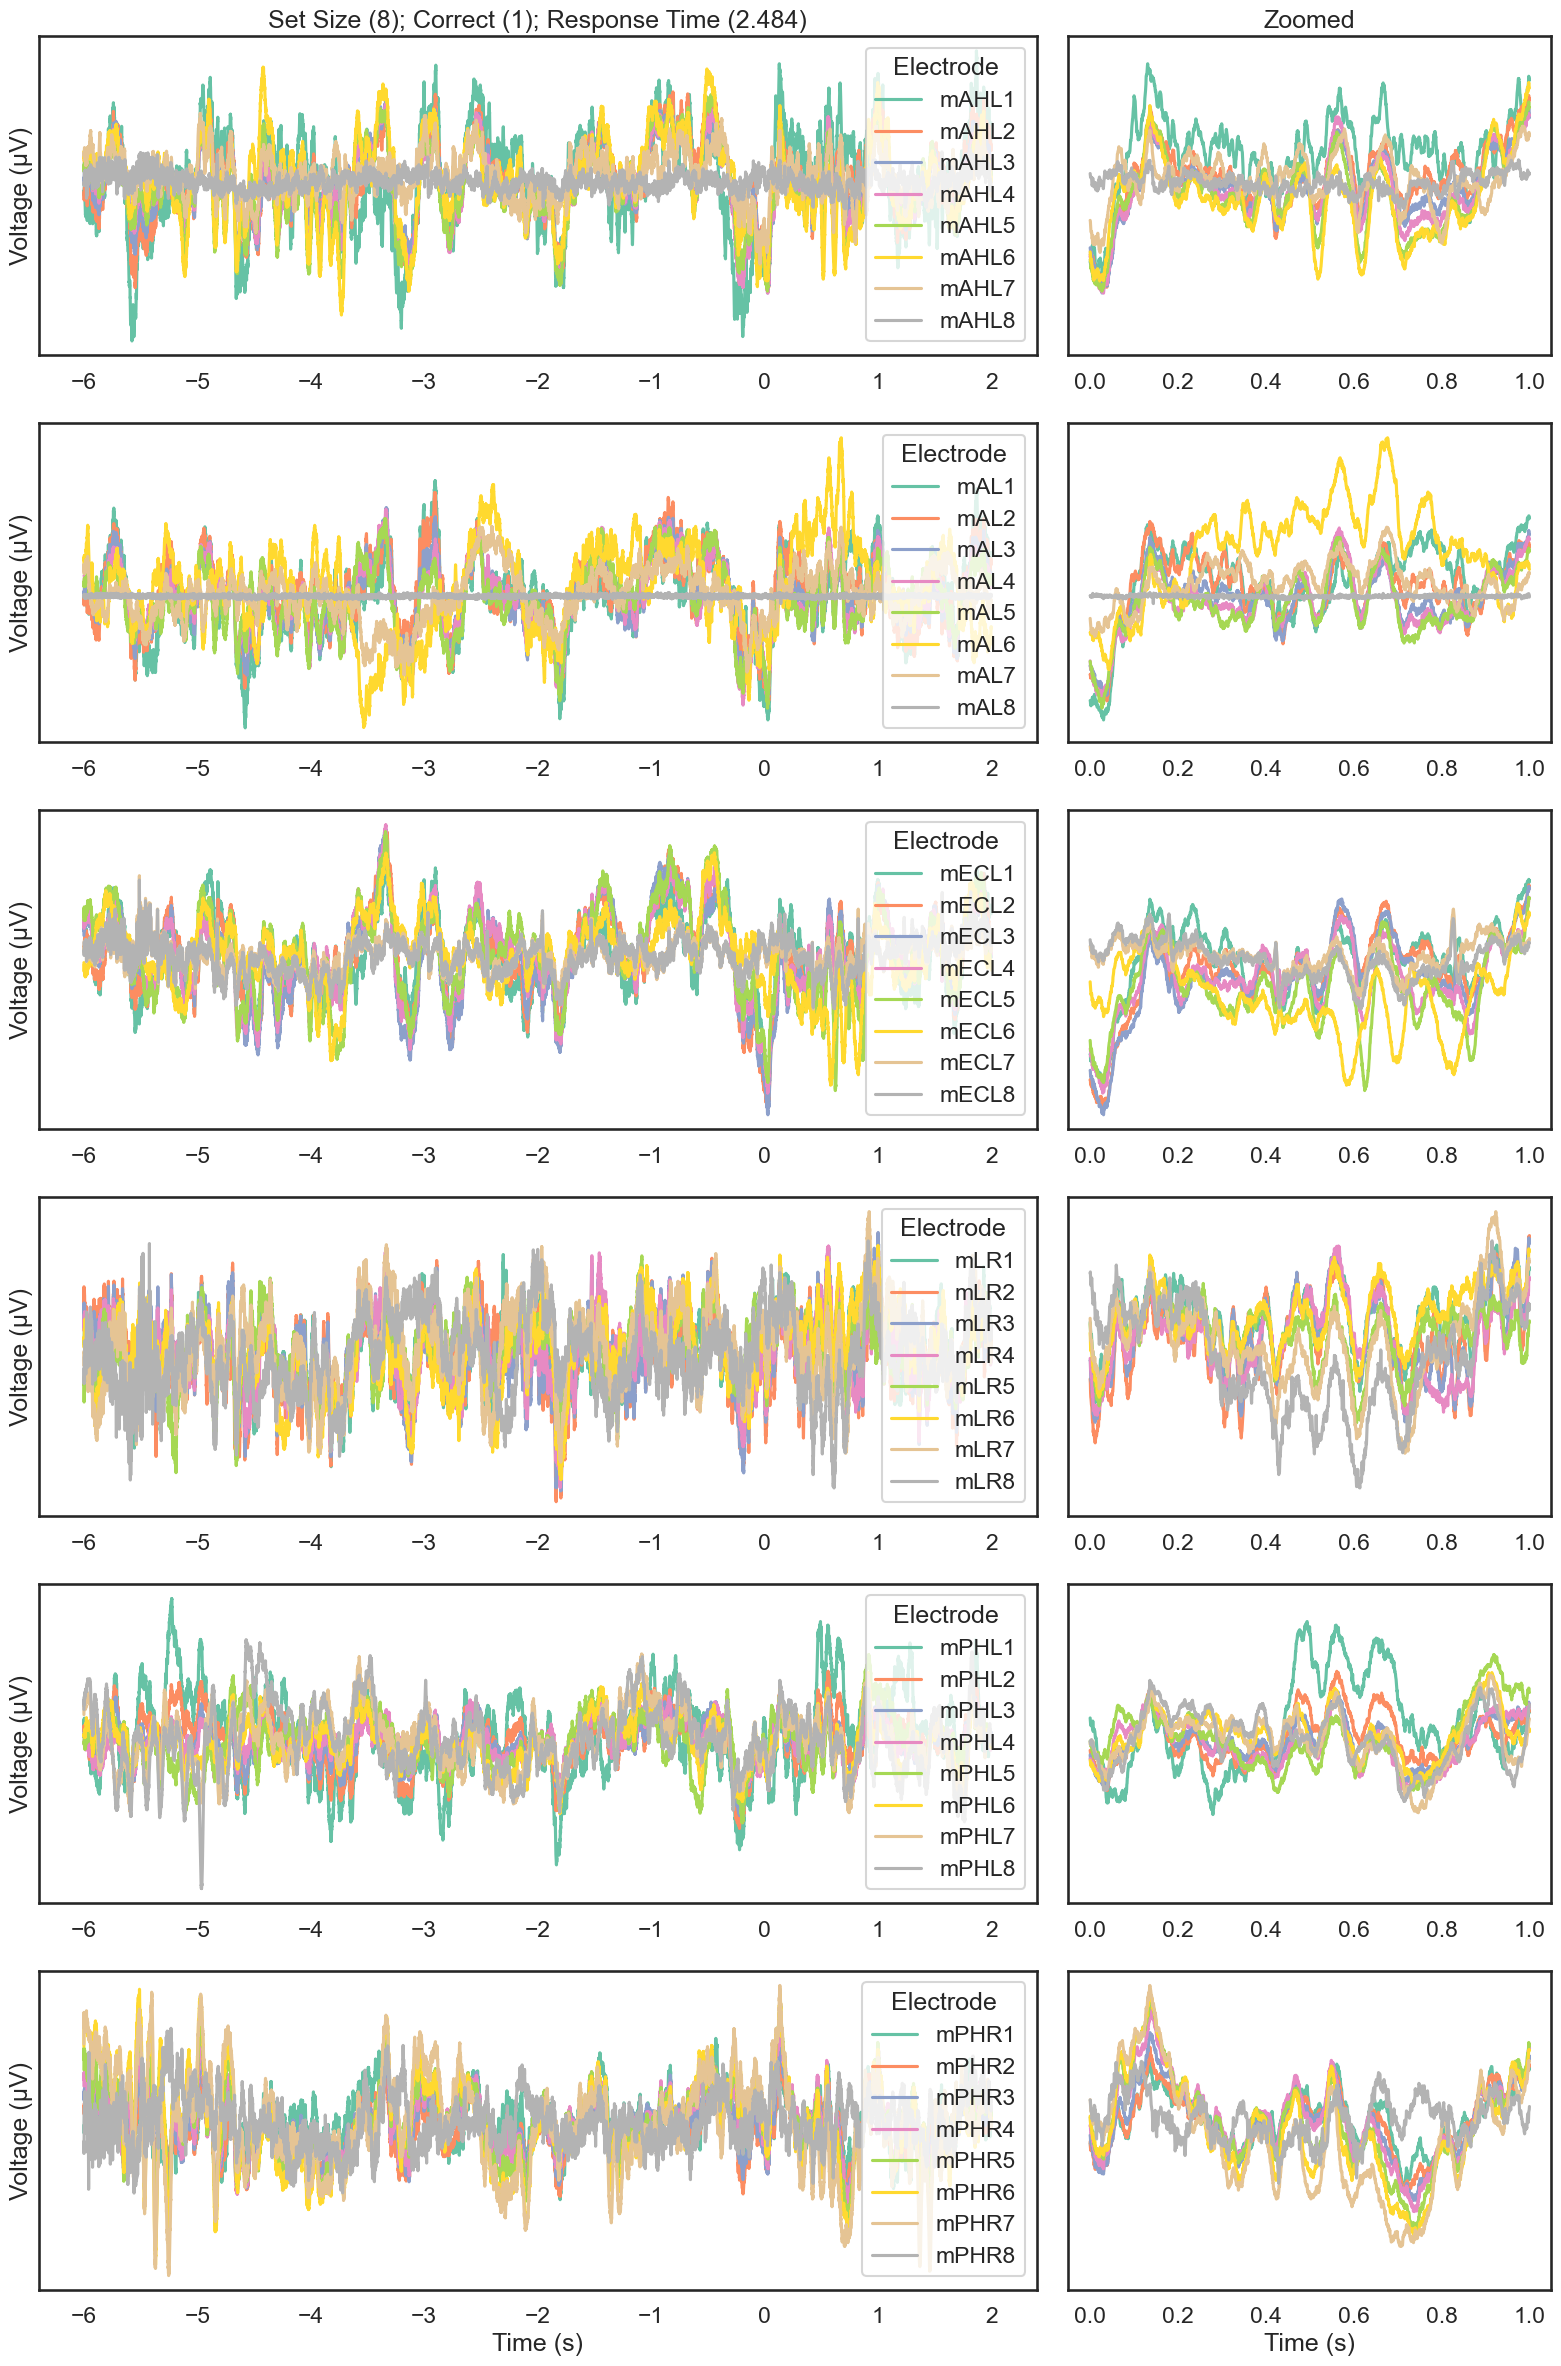

In [4]:
# TODO: Plot brain coordinates
# Set variables
trial_num = 0
time, waveform, electrode_names = data[trial_num]['time'], data[trial_num]['waveform'], data[trial_num]['electrodes']
set_size, correct, response_time = meta[trial_num]['set_size'], meta[trial_num]['correct'], meta[trial_num]['response_time']
df = (
    pd.DataFrame(waveform, index=electrode_names, columns=time)
        .reset_index(names='Electrode')
        .melt(id_vars='Electrode', var_name='Time (s)', value_name='Voltage (μV)')
)

# Make figure
scale = 4
split = int(48/8)  # How many sections?
fig, axs = plt.subplot_mosaic([4*[i] + 2*[i+1] for i in range(0, split*2, 2)], figsize=(scale*4, scale*split))  # sharex=True
# Share x across all vertically stacked plots
[axs[i].sharex(axs[i+2]) for i in range(0, (split*2)-2, 2)]
[axs[(i+1)].sharex(axs[(i+1)+2]) for i in range(0, (split*2)-2, 2)]

# Plot
for i in range(0, split*2, 2):
    # Variables
    last = i == split*2-2

    # Filter to electrodes
    df_filtered = df.loc[df['Electrode'].map(lambda x: x in electrode_names[int(i/2*electrode_names.shape[0]/split):int((i/2+1)*electrode_names.shape[0]/split)])]

    # Regular plot
    plt.sca(axs[i])
    sns.lineplot(
        data=df_filtered,
        x='Time (s)',
        y='Voltage (μV)',
        hue='Electrode',
        ax=axs[i])
    if not last: axs[i].set_xlabel(None)

    # Zoomed plot
    sns.lineplot(
        data=df_filtered.loc[(df_filtered['Time (s)'] >= 0) * (df_filtered['Time (s)'] <= 1)],
        x='Time (s)',
        y='Voltage (μV)',
        hue='Electrode',
        legend=False,
        ax=axs[i+1])
    if not last: axs[i+1].set_xlabel(None)
    axs[i+1].set_ylabel(None)
    axs[i+1].set_yticks([])

    # Share y axis
    axs[i].sharey(axs[i+1])

    # Title based on meta
    if i == 0:
        axs[i].set_title(f'Set Size ({int(set_size):d}); Correct ({int(correct):d}); Response Time ({response_time:.3f})')
        axs[i+1].set_title('Zoomed')

# Formatting
plt.tight_layout()


# iEEG Microelectrode Data (32kHz)

In [5]:
folder='data/hiEEG/000574'

# Load file manually
# file_string = f'sub-01/sub-01_ses-20161214T171300_behavior+ecephys.nwb'
# nwbfile = pynwb.NWBHDF5IO(os.path.join(folder, file_string), mode='r').read()

# Load file automatically
micro_data, micro_meta = load_iEEG_micro(1, 1, folder=folder)


## Visualize

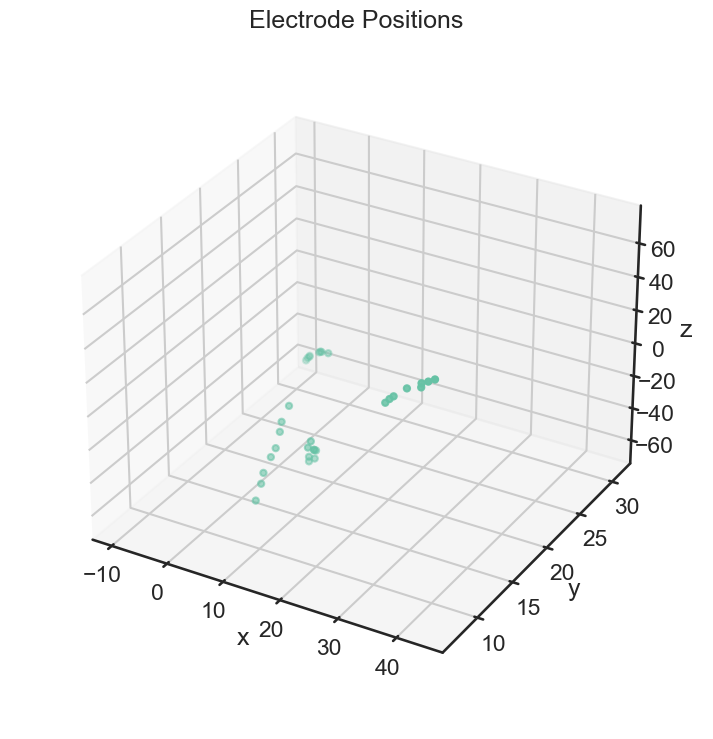

In [22]:
# Show node positions
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(*micro_data['electrode_positions'].T, s=20)
ax.set_title('Electrode Positions')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_box_aspect(aspect=None, zoom=0.9)


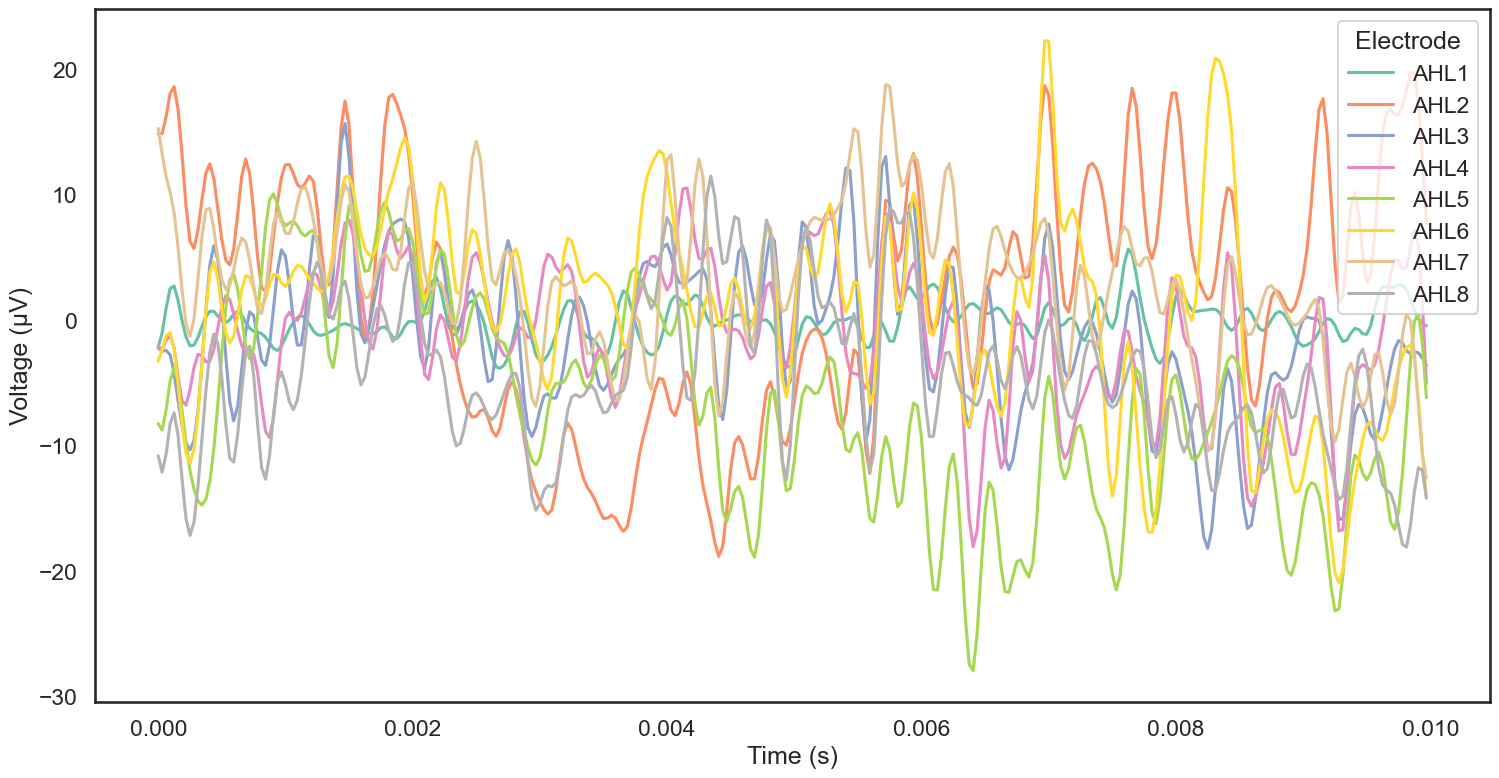

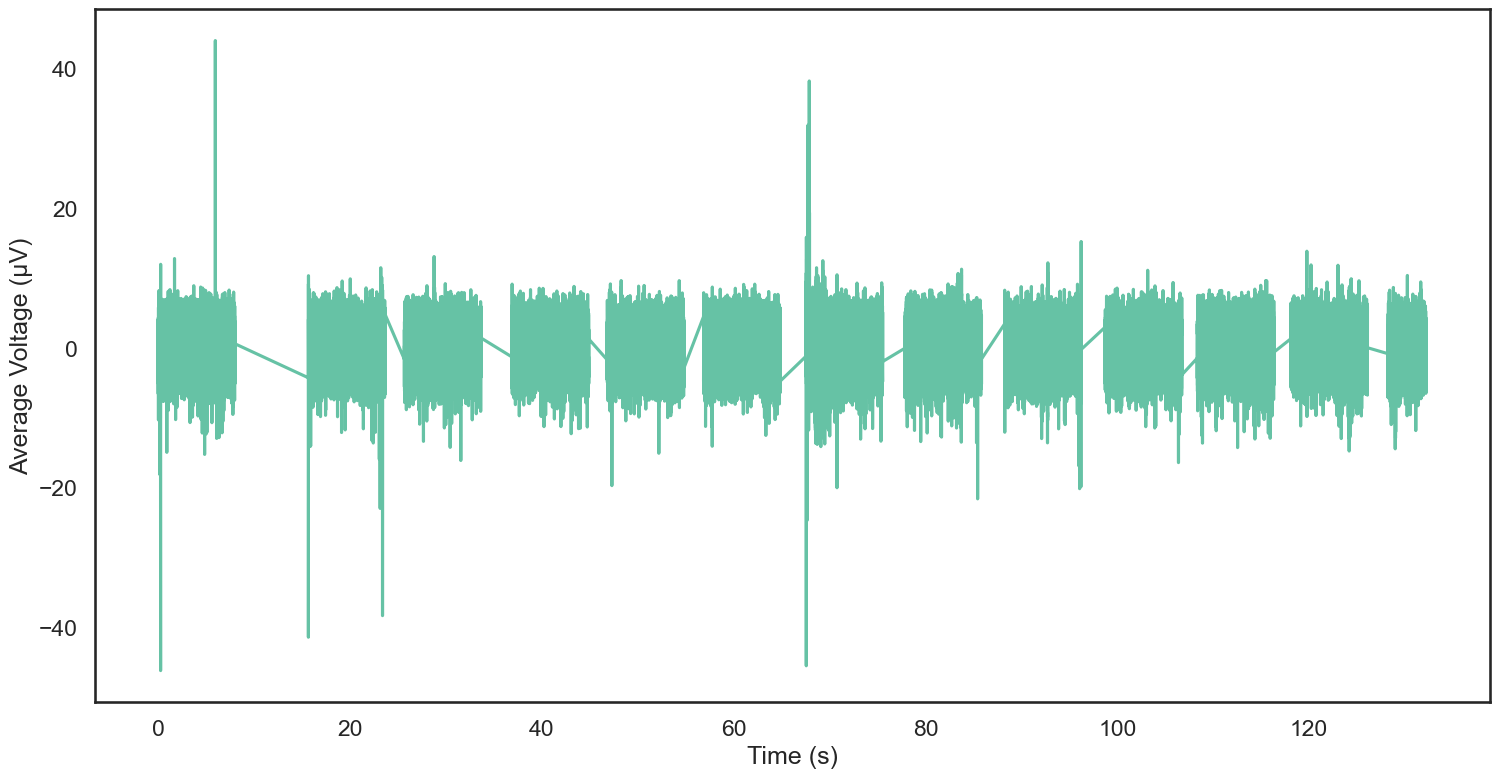

In [7]:
# Plot individual
idx = list(range(int(.01 * 32_000)))
df = pd.DataFrame(micro_data['waveform'][idx], index=pd.Series(micro_data['time'][idx], name='Time (s)'), columns=micro_data['electrodes'])
df = df.reset_index().melt(id_vars='Time (s)', var_name='Electrode', value_name='Voltage (μV)')
step = 8
for i in range(0, micro_data['waveform'].shape[1], step):
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    df_filtered = df.iloc[[s in list(micro_data['electrodes'][i:i+8]) for s in df['Electrode']]]
    sns.lineplot(df_filtered, x='Time (s)', y='Voltage (μV)', hue='Electrode', ax=ax)
    plt.show()
    break  # Remove to show all groups

# Plot average
df = pd.DataFrame({'Time (s)': micro_data['time'], 'Average Voltage (μV)': micro_data['waveform'].mean(axis=1)})
idx = list(range(int(100 * 32_000)))
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
sns.lineplot(df.iloc[idx], x='Time (s)', y='Average Voltage (μV)', ax=ax)
plt.show()
